In [1]:
import gurobipy as gp
import pandas as pd
import numpy as np

In [2]:
def solve(obj, A, sense, b, lb = None, ub = None, min_max = 'maximize', vtype = None):
    # Model initialization
    model = gp.Model()
    
    # Variables initialization
    modelX = model.addMVar(obj.shape[0], lb=None, ub=None, vtype=vtype)
    
    
    # Constraint intialization
    modelConstr = model.addMConstr(A, modelX, sense, b)
    
    #  objective init
    if min_max == 'maximize':
        model.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
    if min_max == 'minimize':
        model.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)
    
    model.Params.OutputFlag = 0 # restricting output jargon
    
    model.optimize()
    
    print("\nobjective value")
    print(model.objVal)
    print('-----------------------------------')

    print("\nvalues of variable X")
    print(modelX.x)
    for i in range(len(modelX.x)):
        print(i+1 ,'-->', modelX.x[i])
    
    print('-----------------------------------')

# Q2

In [3]:
# objective definition
obj = np.array([9, 5, 6, 4])

# contraint definition
A = np.zeros((2,4))

# constraint matrix fillup
A[0,:] = [6, 3, 5, 2]
A[1,:] = [1, 1, 0, 0]

# sense definition
sense = np.array(['<', '<'])

# constraint RHS definition
b = np.array([11, 2])


solve(obj, A, sense, b, min_max='maximize', vtype = ['B']*obj.shape[0])

Restricted license - for non-production use only - expires 2022-01-13

objective value
18.0
-----------------------------------

values of variable X
[1. 1. 0. 1.]
1 --> 1.0
2 --> 1.0
3 --> 0.0
4 --> 1.0
-----------------------------------


Is building the Factory in Dallas part of the optimal investment strategy? 

**Yes**

Can we take mod in this ? 

# Q3

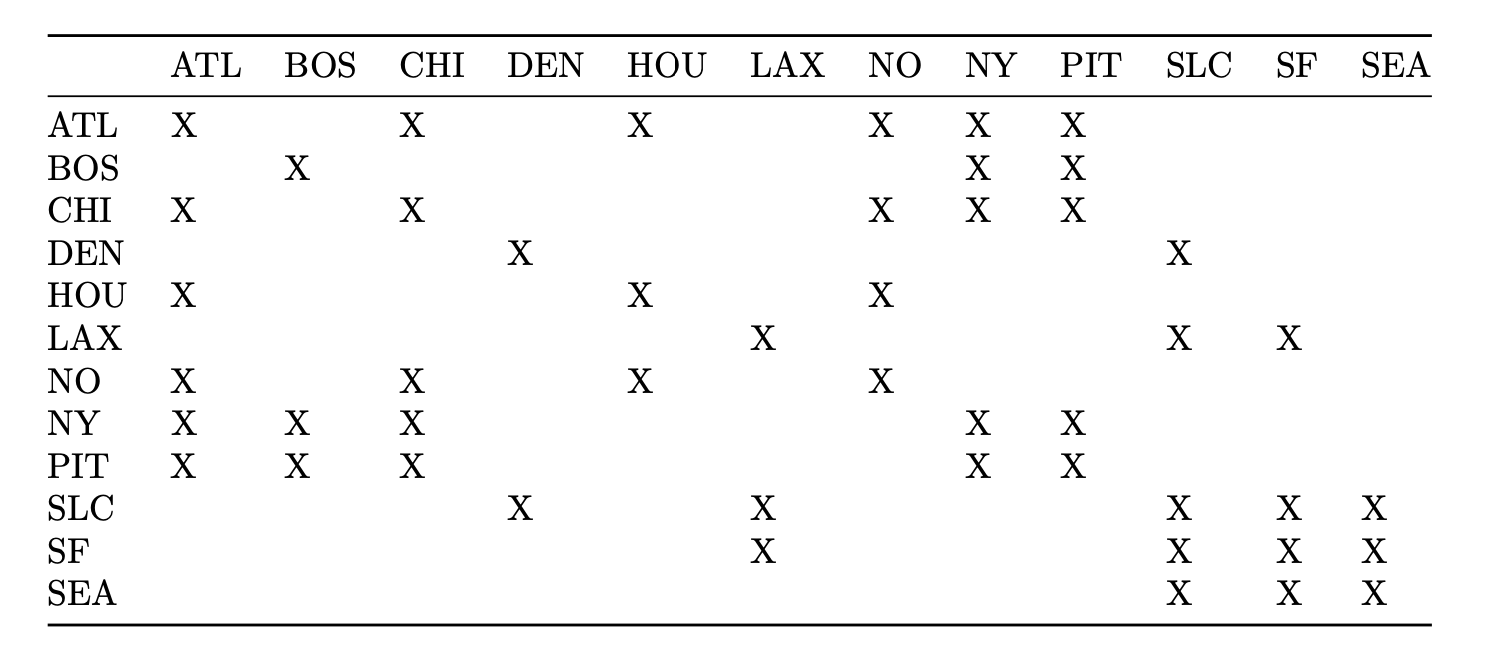

In [80]:
# objective definition
obj = np.array([1] * 12)

# contraint definition
A = np.zeros((12, 12))

# constraint matrix fillup
A[0,[0, 2, 4, 6, 7, 8]] = [1]*6
A[1,[1, 7, 8]] = [1]*3
A[2,[2, 0, 6, 7, 8]] = [1]*5
A[3,[3, 9]] = [1]*2
A[4,[4, 0, 6]] = [1]*3
A[5,[5, 9, 10]] = [1]*3
A[6,[6, 0, 2, 4]] = [1]*4
A[7,[7, 0, 1, 2, 8]] = [1]*5
A[8,[8, 0, 1, 2, 7]] = [1]*5
A[9,[9, 3, 5, 10, 11]] = [1]*5
A[10,[10, 5, 9, 11]] = [1]*4
A[11,[11, 9, 10]] = [1]*3

# sense definition
sense = np.array(['>']*12)
# constraint RHS definition
b = np.array([1]*12)

solve(obj, A, sense, b, min_max='minimize', vtype = ['B']*obj.shape[0])


objective value
3.0
-----------------------------------

values of variable X
[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
1 --> 1.0
2 --> 0.0
3 --> 0.0
4 --> 0.0
5 --> 0.0
6 --> 0.0
7 --> 0.0
8 --> 0.0
9 --> 1.0
10 --> 1.0
11 --> 0.0
12 --> 0.0
-----------------------------------


Is SLC a hub in the optimal solution?

**Yes**

# Q3

## My solution

In [115]:
# objective definition
obj = np.array([12, 9, 20, 4, 8, 16, 21])

# contraint definition
A = np.zeros((3, 7))

# constraint matrix fillup
A[0,:] = [0, 0, 4, 1, 3, 2, 1]
A[1,:] = [0, 3, 0, 1, 1, 0, 2]
A[2,:] = [2, 0, 0, 1, 0, 0, 0]

# sense definition
sense = np.array(['>']*3)
# constraint RHS definition
b = np.array([233, 148, 106])

solve(obj, A, sense, b, min_max='minimize', vtype = ['I']*obj.shape[0])


objective value
764.0
-----------------------------------

values of variable X
[ -0.  -0.   0. 107.  42.  -0.  -0.]
1 --> -0.0
2 --> -0.0
3 --> 0.0
4 --> 107.0
5 --> 42.0
6 --> -0.0
7 --> -0.0
-----------------------------------


How many rolls get cut into the pattern such that there are 3 cuts of 25 inches, and 1 cut of 37 inches (this pattern results in 8" waste)?

**42**

Vtype `C` giving values in decimal, changed it to `I`

## Solution copied from net to match the answer

In [116]:
"""
cutstock.py:  use gurobi for solving the cutting stock problem.

The instance of the cutting stock problem is represented by the two
lists of m items of size and quantity s=(s_i) and q=(q_i).

The roll size is B.

Given packing patterns t_1, ...,t_k,...t_K where t_k is a vector of
the numbers of items cut from a roll, the problem is reduced to the
following LP:
    
    minimize   sum_{k} x_k
    subject to sum_{k} t_k(i) x_k >= q_i    for all i
	       x_k >=0			    for all k.

We apply a column generation approch (Gilmore-Gomory approach) in
which we generate cutting patterns by solving a knapsack sub-problem.

Copyright (c) by Joao Pedro PEDROSO and Mikio KUBO, 2010
"""

from gurobipy import *

LOG = True
EPS = 1.e-6

def solveCuttingStock(s, B):
    """solveCuttingStock: use Haessler's heuristic.
    
    Parameters:
        s - list with item widths
        B - bin capacity

    Returns a solution: list of lists, each of which with the cuts of a roll.
    """
    w = []   # list of different widths (sizes) of items
    q = []   # quantitiy of orders  
    for item in sorted(s):
        if w == [] or item != w[-1]:
            w.append(item)
            q.append(1)
        else:
            q[-1] += 1

    t = []	# patterns
    m = len(w)
    # generate initial patterns with one size for each item width
    for i,width in enumerate(w):
        pat = [0]*m  # vector of number of orders to be packed into one roll (bin)
        pat[i] = int(B/width)
        t.append(pat)

    if LOG:
        print("sizes of orders=", w)
        print("quantities of orders=", q)
        print("roll size=", B)
        print("initial patterns", t)

    iter = 0
    K = len(t)
    master = Model("LP") # master LP problem
    x = {}
    for k in range(K):
        x[k] = master.addVar(obj=1, vtype="I", name="x[%d]"%k)
    master.update()

    orders={}
    for i in range(m):
        coef = [t[k][i] for k in range(K) if t[k][i] > 0]
        var = [x[k] for k in range(K) if t[k][i] > 0]
        orders[i] = master.addConstr(LinExpr(coef,var), ">", q[i], name="Order[%d]"%i)

    master.update()   # must update before calling relax()
    master.Params.OutputFlag = 0 # silent mode
    
    
    # master.write("MP" + str(iter) + ".lp")

    while 1:
        iter += 1
        relax = master.relax()
        relax.optimize()
        pi = [c.Pi for c in relax.getConstrs()] # keep dual variables

        knapsack = Model("KP")   # knapsack sub-problem
        knapsack.ModelSense=-1   # maximize
        y = {}
        for i in range(m):
            y[i] = knapsack.addVar(obj=pi[i], ub=q[i], vtype="I", name="y[%d]"%i)
        knapsack.update()

        L = LinExpr(w, [y[i] for i in range(m)])
        knapsack.addConstr(L, "<", B, name="width")
        knapsack.update()
        # knapsack.write("KP"+str(iter)+".lp")
        knapsack.Params.OutputFlag = 0 # silent mode
        knapsack.optimize()
        if LOG:
            print("objective of knapsack problem:", knapsack.ObjVal)
        if knapsack.ObjVal < 1+EPS: # break if no more columns
            break

        pat = [int(y[i].X+0.5) for i in y]	# new pattern
        t.append(pat)
        if LOG:
            print("shadow prices and new pattern:")
            for i,d in enumerate(pi):
                print("\t%5d%12g%7d" % (i,d,pat[i]))
            print()

        # add new column to the master problem
        col = Column()
        for i in range(m):
            if t[K][i] > 0:
                col.addTerms(t[K][i], orders[i])
        x[K] = master.addVar(obj=1, vtype="I", name="x[%d]"%K, column=col)
        master.update()   # must update before calling relax()
        # master.write("MP" + str(iter) + ".lp")
        K += 1


    # Finally, solve the IP
    if LOG:
        master.Params.OutputFlag = 0 # verbose mode
    master.optimize()

    if LOG:
        print()
        print("final solution (integer master problem):  objective =", master.ObjVal)
        print("patterns:")
        for k in x:
            if x[k].X > EPS:
                print("pattern", k)
                print("\tsizes:")
                print([w[i] for i in range(m) if t[k][i]>0 for j in range(t[k][i]) ])
                print("--> %d rolls" % int(x[k].X+.5))

    rolls = []
    for k in x:
        for j in range(int(x[k].X + .5)):
            rolls.append(sorted([w[i] for i in range(m) if t[k][i]>0 for j in range(t[k][i])]))
    rolls.sort()
    return rolls

    

def FFD(s, B):
    """First Fit Decreasing heuristics for the Bin Packing Problem.

    Parameters:
        s - list with item widths
        B - bin capacity
    """    
    remain = [B]	# keep list of empty space per bin
    sol = [[]]		# a list ot items (i.e., sizes) on each used bin
    for item in sorted(s, reverse=True):
        for j,free in enumerate(remain):
            if free >= item:
                remain[j] -= item
                sol[j].append(item)
                break
        else: #does not fit in any bin
            sol.append([item])
            remain.append(B-item)

    return sol
    


def solveBinPacking(s,B):
    """solveBinPacking: use an IP model to solve the in Packing Problem.
    
    Parameters:
        s - list with item widths
        B - bin capacity

    Returns a solution: list of lists, each of which with the items in a roll.
    """
    n = len(s)
    U = len(FFD(s,B)) # upper bound of the number of bins
    model = Model("bpp")
    # setParam("MIPFocus",1)
    x = {}
    listX = {} # for SOS constraints	!!!!!!!!!!!!!!!!!!!
    for i in range(n):
        listX[i] = [] 
        for j in range(U):
            x[i,j] = model.addVar(vtype="B", name="x[%d,%d]"%(i,j))
            listX[i].append(x[i,j])
    y = {}
    for j in range(U):
        y[j] = model.addVar(obj=1, vtype="B", name="y[%d]"%j)    
    model.update()

    # assignment constraints
    for i in range(n):
        var = [x[i,j] for j in range(U)]
        coef = [1] * U
        model.addConstr(LinExpr(coef,var), "=", 1, name="cnstr1[%d]"%i)

    # bin capacity constraints
    for j in range(U):
        var = [x[i,j] for i in range(n)]
        coef = [s[i] for i in range(n)]
        model.addConstr(LinExpr(coef,var), "<", LinExpr(B,y[j]), name="cnstr2[%d]"%j)

    # tighten assignment constraints
    for j in range(U):
        for i in range(n):
            model.addConstr(x[i,j], "<", y[j], name="cnstr3[%d,%d]"%(i,j))
        
##    # tie breaking constraints
##    for j in range(U-1):
##        lin=LinExpr()
##        lin.addTerms(1,y[j])
##        lin.addTerms(-1,y[j+1])
##        model.addConstr(lhs=lin,sense=GRB.GREATER_EQUAL,rhs=0,name="constraint4_"+str(j))
##
##    # SOS constraints
##    for i in range(n):
##        model.addSOS(1,listX[i])

    if not LOG:
        model.Params.outputflag = 0
    model.optimize()
    
    bins = [[] for i in range(U)]
    for (i,j) in x:
        if x[i,j].X > EPS:
            bins[j].append(s[i])
    for i in range(bins.count([])):
        bins.remove([])
    for b in bins:
        b.sort()
    bins.sort()
    return bins


def CuttingStockExample2():
    """CuttingStockExample2: create toy instance for the cutting stock problem."""
    B = 120              # roll width (bin size)  
    w = [25, 37, 54]     # width (size) of orders (items)
    q = [233, 148, 106]  # quantitiy of orders
    s=[]
    for j in range(len(w)):
        for i in range(q[j]):
            s.append(w[j])
    return s,B

In [117]:
s,B = CuttingStockExample2()

In [118]:
rolls = solveCuttingStock(s,B)

sizes of orders= [25, 37, 54]
quantities of orders= [233, 148, 106]
roll size= 120
initial patterns [[4, 0, 0], [0, 3, 0], [0, 0, 2]]
objective of knapsack problem: 1.0833333333333333
shadow prices and new pattern:
	    0        0.25      3
	    1    0.333333      1
	    2         0.5      0

objective of knapsack problem: 1.0555555555555554
shadow prices and new pattern:
	    0    0.222222      1
	    1    0.333333      1
	    2         0.5      1

objective of knapsack problem: 1.0

final solution (integer master problem):  objective = 149.0
patterns:
pattern 0
	sizes:
[25, 25, 25, 25]
--> 1 rolls
pattern 3
	sizes:
[25, 25, 25, 37]
--> 42 rolls
pattern 4
	sizes:
[25, 37, 54]
--> 106 rolls


C:\Users\mehen\AppData\Local\Temp/ipykernel_11812/1164242341.py:1: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  rolls = solveCuttingStock(s,B)


# Q5

In [119]:
# objective definition
obj = np.array([330, 300, 330, 360, 360, 360, 360])

# contraint definition
A = np.zeros((7, 7))

# constraint matrix fillup
A[0,:] = [1, 0, 0, 1, 1, 1, 1]
A[1,:] = [1, 1, 0, 0, 1, 1, 1]
A[2,:] = [1, 1, 1, 0, 0, 1, 1]
A[3,:] = [1, 1, 1, 1, 0, 0, 1]
A[4,:] = [1, 1, 1, 1, 1, 0, 0]
A[5,:] = [0, 1, 1, 1, 1, 1, 0]
A[6,:] = [0, 0, 1, 1, 1, 1, 1]

# sense definition
sense = np.array(['>']*7)
# constraint RHS definition
b = np.array([5, 13, 12, 10, 14, 8, 6])

solve(obj, A, sense, b, min_max='minimize', vtype = ['C']*obj.shape[0])


objective value
4830.0
-----------------------------------

values of variable X
[1. 8. 2. 0. 3. 1. 0.]
1 --> 1.0
2 --> 8.0
3 --> 2.0
4 --> 0.0
5 --> 3.0
6 --> 1.0
7 --> 0.0
-----------------------------------


How many employees work Monday-Friday?

**8.0**

In [122]:
s = np.array([ 1,  8,  2, -0,  3, 1, -0,]).T
C = np.zeros(A.shape)
for i in range(len(A)):
    C[i,:] = A[:, i] * s[i]

In [123]:
C

array([[1., 1., 1., 1., 1., 0., 0.],
       [0., 8., 8., 8., 8., 8., 0.],
       [0., 0., 2., 2., 2., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0.],
       [3., 3., 0., 0., 3., 3., 3.],
       [1., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [124]:
print(C.sum(axis = 0))

[ 5. 13. 12. 11. 14. 14.  6.]
